In [433]:
%reload_ext autoreload
%autoreload 2

from agama_spray import *
from utils import *
from models_streams import *

In [463]:
params = [
    1.331894490855406588e+01,
    2.441091252550232582e+01,
    9.783571786742331078e-01,
    8.830960963814488140e-01,
    1.875641070271489019e-01,
    9.683001634771329913e-01,
    8.012867222690761793e+00,
    2.037439625282703393e+00,
    9.089267564398808474e+01,
    3.578894919126337726e+01,
    4.226245547900189337e+01,
    2.926375566231026681e+00,
    4.147323622050326231e-01,
    -3.735887079750737638e-01,
    7.304075075100886494e-01,
    5.421078379317691542e+00
]

# params = [
#     1.273146053477989703e+01,
#     8.150149182871693654e+00,
#     8.173321171888225933e-01,
#     4.116978099996190105e-02,
#     -1.553360237214720607e+00,
#     3.369010603844647955e-02,
#     8.535122153647941801e+00,
#     2.821441644893481371e+00,
#     9.074995066003567956e+01,
#     5.763763249637054997e+01,
#     5.452864009444621018e+01,
#     2.736758445282009067e+00,
#     7.920840615683139019e-01,
#     -1.603054560515305482e+00,
#     -1.414495851287524697e-01,
#     3.734879646494004390e+00
# ]

# params = [
#     1.297304934486500194e+01,
#     2.016255361991831307e+01,
#     1.012929123027472400e+00,
#     -2.337864951967188354e+00,
#     9.733524312100153009e-02,
#     7.135679786312922046e-02,
#     8.762594501908292699e+00,
#     1.030200721233757166e+00,
#     4.578864180542305462e+01,
#     1.224235199541085422e+02,
#     4.972684041571798730e+01,
#     2.892587181791508755e+00,
#     -1.381133314150513047e-01,
#     -6.953875523159055994e-02,
#     3.189788907757262204e-01,
#     4.619190845600189554e+00
# ]
# params = [
#     1.402358441813668577e+01,
#     2.308022091747244531e+01,
#     1.096237775758324151e+00,
#     -1.458244916451303108e-01,
#     -5.699556992087286833e-01,
#     7.606917965339747845e-01,
#     8.949375726924444052e+00,
#     1.167880638527937887e+00,
#     -1.281386604789250896e+02,
#     1.502143169260923514e+02,
#     1.447565595870579784e+02,
#     2.929829992029671981e+00,
#     1.992331609968293199e-02,
#     -1.165976267292455210e-01,
#     -7.004224453790691696e-02,
#     3.154012565205617236e+00
# ]


In [464]:
logM, Rs, q, dirx, diry, dirz, logm, rs, pos_init_x, pos_init_y, pos_init_z, logv, dirvx, dirvy, dirvz, time_total = params

rot_mat = get_mat(dirx, diry, dirz)
rot = R.from_matrix(rot_mat)
euler_angles = rot.as_euler('xyz', degrees=False)

densitynorm = compute_densitynorm(10**logM, Rs, q)
pot_host = agama.Potential(type='Spheroid', densitynorm=densitynorm, scaleradius=Rs, gamma=1, alpha=1, beta=3, 
                            axisRatioY=1, axisRatioZ=q, orientation=euler_angles)

num_particles = int(1e4)  # number of particles in the stream

v_dir = np.array([dirvx, dirvy, dirvz])
v_dir = v_dir/np.linalg.norm(v_dir)
vx = 10**logv * v_dir[0]
vy = 10**logv * v_dir[1]
vz = 10**logv * v_dir[2]

posvel_sat = np.array([pos_init_x, pos_init_y, pos_init_z, vx, vy, vz])

xyz_stream, gamma, xyz_orbit, time_orbit = create_stream_particle_spray_with_progenitor(time_total, num_particles, pot_host, posvel_sat, 10**logm, rs, pieces='both', gala_modified=True)
x_stream, y_stream = xyz_stream[:, -1, 0], xyz_stream[:, -1, 1]


_, futur_orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat, time=1, trajsize=len(time_orbit)+1)
x_futur = futur_orbit_sat[:,0]
y_futur = futur_orbit_sat[:,1]


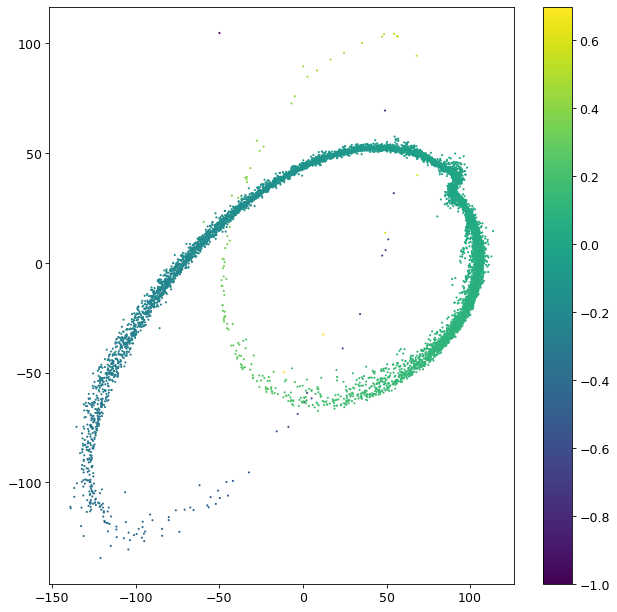

In [466]:
plt.figure(figsize=(10, 10))
plt.scatter(xyz_stream[:, -1, 0], xyz_stream[:, -1, 1], s=1, c=gamma, cmap='viridis')
plt.colorbar()
# plt.scatter(xyz_orbit[:, 0], xyz_orbit[:, 1], s=1, c='red')
# plt.plot(x_futur, y_futur, c='b')



In [456]:
# Define the number of bins
num_bins = 30
uniform = 'linear'
min_particule = 13

if uniform == 'linear':
    # Compute the bin edges such that each bin has a constant size
    bin_edges = np.linspace(np.min(gamma), np.max(gamma), num_bins + 1)
elif uniform == 'count':
    # Compute the bin edges such that each bin has an equal number of points
    bin_edges = np.percentile(gamma, np.linspace(0, 100, num_bins + 1))

# Bin the gamma values
indices = np.digitize(gamma, bin_edges)

# Compute the average x_stream, y_stream, and r_stream in each bin if there are at least 5 points
average_x_in_bins = [np.median(x_stream[indices == i]) if np.sum(indices == i) >= min_particule else None for i in range(1, num_bins + 1)]
average_y_in_bins = [np.median(y_stream[indices == i]) if np.sum(indices == i) >= min_particule else None for i in range(1, num_bins + 1)]
average_r_in_bins = [np.median(r_stream[indices == i]) if np.sum(indices == i) >= min_particule else None for i in range(1, num_bins + 1)]

In [457]:
arg_keep = np.where( np.array(average_x_in_bins) != None)
average_gamma = bin_edges[:-1][arg_keep]
average_x = np.array(average_x_in_bins)[arg_keep]
average_y = np.array(average_y_in_bins)[arg_keep]

x_spline = CubicSpline(average_gamma, average_x)
y_spline = CubicSpline(average_gamma, average_y)


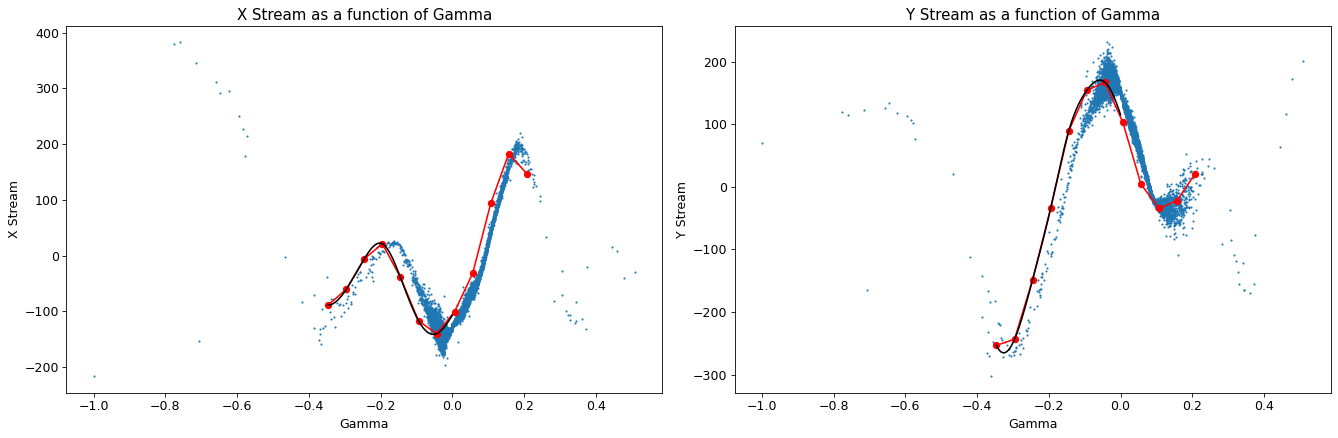

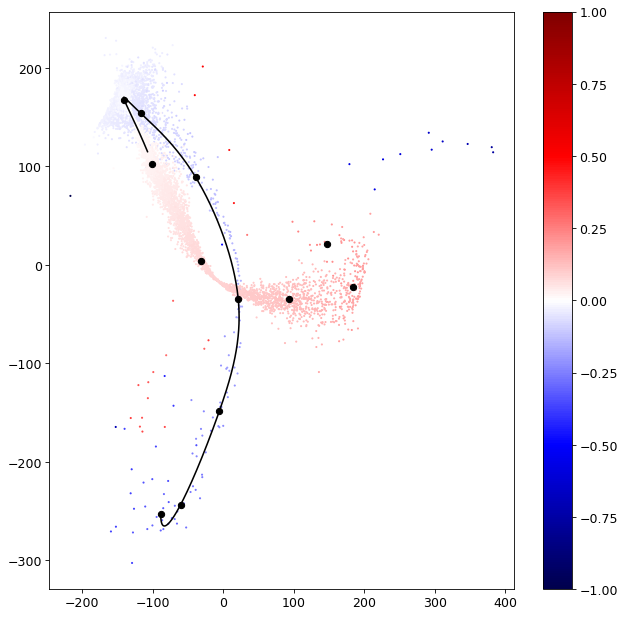

In [458]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(gamma, x_stream, color='tab:blue', s=1)
plt.plot(bin_edges[:-1], average_x_in_bins, 'ro-')
theo_gamma = np.linspace(average_gamma[0], 0, 1000)
plt.plot(theo_gamma, x_spline(theo_gamma), 'k-')
plt.xlabel('Gamma')
plt.ylabel('X Stream')
plt.title('X Stream as a function of Gamma')

plt.subplot(1, 2, 2)
plt.scatter(gamma, y_stream, color='tab:blue', s=1)
plt.plot(bin_edges[:-1], average_y_in_bins, 'ro-')
theo_gamma = np.linspace(average_gamma[0], 0, 1000)
plt.plot(theo_gamma, y_spline(theo_gamma), 'k-')
plt.xlabel('Gamma')
plt.ylabel('Y Stream')
plt.title('Y Stream as a function of Gamma')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(xyz_stream[:, -1, 0], xyz_stream[:, -1, 1], s=1, c=gamma, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()
# plt.plot(average_x_in_bins, average_y_in_bins, 'ko-')#, s=10)
plt.plot(x_spline(theo_gamma), y_spline(theo_gamma), 'k-')
plt.scatter(average_x, average_y, color='k')


In [459]:
%reload_ext autoreload
%autoreload 2

from utils import *
pieces = 'leading'

In [460]:
x_stream, y_stream = xyz_stream[:, -1, 0], xyz_stream[:, -1, 1]

if uniform == 'linear':
    # Compute the bin edges such that each bin has a constant size
    bin_edges = np.linspace(np.min(gamma), np.max(gamma), num_bins + 1)
elif uniform == 'count':
    # Compute the bin edges such that each bin has an equal number of points
    bin_edges = np.percentile(gamma, np.linspace(0, 100, num_bins + 1))

# Bin the gamma values
indices = np.digitize(gamma, bin_edges)

average_x_in_bins, average_y_in_bins, average_gamma_in_bins = [], [], []
for i in range(1, num_bins + 1):
    if np.sum(indices == i) >= min_particule:
        average_x_in_bins.append(np.median(x_stream[indices == i]))
        average_y_in_bins.append(np.median(y_stream[indices == i]))
        average_gamma_in_bins.append(np.median(gamma[indices == i]))
average_x = np.array(average_x_in_bins)
average_y = np.array(average_y_in_bins)
average_gamma = np.array(average_gamma_in_bins)

if pieces == 'leading':
    arg_leading = average_gamma > 0
    average_gamma = average_gamma[arg_leading]
    average_x = average_x[arg_leading]
    average_y = average_y[arg_leading]
elif pieces == 'trailing':
    arg_trailing = average_gamma < 0
    average_gamma = average_gamma[arg_trailing]
    average_x = average_x[arg_trailing]
    average_y = average_y[arg_trailing]

curvature = compute_curvature(average_x, average_y).sum()

if curvature < 0:
    print('yo')
    average_x = average_x[::-1]
    average_y = average_y[::-1]

average_r = np.sqrt(average_x**2 + average_y**2)
average_theta = np.arctan2(average_y, average_x)
average_theta[average_theta < 0] += 2*np.pi
average_theta = np.unwrap(average_theta)

r_spline = CubicSpline(average_theta, average_r)

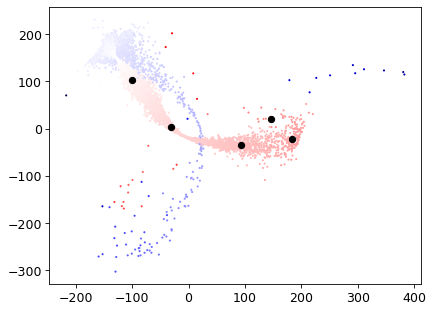

In [461]:
new_average_x, new_average_y = average_r * np.cos(average_theta), average_r * np.sin(average_theta)
plt.scatter(xyz_stream[:, -1, 0], xyz_stream[:, -1, 1], s=1, c=gamma, cmap='seismic', vmin=-1, vmax=1)
plt.scatter(new_average_x, new_average_y, color='k')

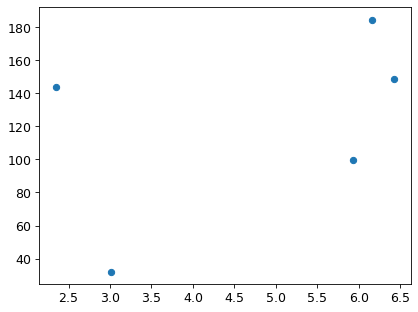

In [462]:
plt.scatter(average_theta, average_r)

In [15]:

%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from mock_data import *
from priors import *
from models_streams import *
from utils import *

In [2]:
q_true = 1.
model = agama_stream_model_ndim16
prior_trainsform = stream_large_prior_transform_ndim16
model_spline = get_spline_for_stream
ndim = 16

dict_data, params, spline, theta_track = get_mock_data(q_true, 
                                        model,
                                        prior_trainsform,
                                        model_spline,
                                        ndim,
                                        pieces='leading',
                                        seed=1, sigma=10, n_ang=72, min_particle=3, max_dist=80)

260.4913069425242 279.805321849603 181.71036102212094 263.59419628777306
338.18389403501175 341.59352442959505 198.80095698426788 215.79799713880072
242.313148970602 526.2026130128131 3.0377143294095186 305.1816813058798
163.12005073954583 206.58300798651894 56.56486870936039 328.72316419179595
244.11264477712766 555.0411064691101 8.156642175512292 272.75068418880545
277.8758589034584 287.2986042705736 142.4242679073514 187.79764069607737
278.4260253667062 282.32125649707234 605.5814896032807 634.006076921545
16.528341695523824 263.6279461457766 51.395414775208984 120.21797707142343


In [20]:
dict_data

{'theta': array([0.288474, 0.602633, 0.916793, 1.230952, 1.545111, 1.85927 , 2.17343 , 2.487589, 2.801748, 3.115907, 3.430067, 3.744226, 4.058385, 4.372544]),
 'r': array([139.704257,  85.59238 ,  72.832553,  66.15731 ,  57.071802,  55.931668,  63.595995,  57.924147,  47.941908,  57.541964,  50.542089,  47.647349,  44.4371  ,  63.765399]),
 'x': array([133.931555,  70.514932,  44.309062,  22.052913,   1.465744, -15.911978, -36.047089, -45.971753, -45.199942, -57.522984, -48.453646, -39.254074, -27.03415 , -21.255592]),
 'y': array([ 39.744408,  48.514944,  57.803874,  62.373542,  57.052977,  53.620522,  52.393301,  35.239251,  15.980981,   1.477819, -14.378698, -27.007176, -35.267698, -60.118433]),
 'r_sig': array([12.021798,  9.309778,  7.471288,  6.37187 ,  5.877025,  5.821253,  5.952451,  6.004624,  5.837969,  5.553253,  5.278268,  5.1408  ,  5.268641,  5.789579]),
 'noise': array([ 19.48628 ,  -7.505402,  -1.880331,   2.438611,  -1.698445,  -2.280861,   4.071484,  -2.122094, -10.43

In [22]:
p = np.random.uniform(0, 1, 15)
params = stream_large_prior_transform_ndim15(p)
from utils import *
from likelihoods import *
model_log_likelihood(params, dict_data, agama_stream_model_ndim15, get_spline_for_stream, dict_data['theta'][0], pieces='leading')

-2e+100